In [ ]:
# TODO: clean imports
import numpy as np
import torch
import gpytorch
from easygpr import GPRModel
import matplotlib.pyplot as plt
import easygpr.utils as utils

from easygpr.utils.settings import set_gpytorch_settings

set_gpytorch_settings()


Fitting complete.
--- 
--- final mll: -1.5190
--- num_params: 4
--- BIC: 15.0210
Fitting complete.
--- 
--- final mll: -1.5011
--- num_params: 4
--- BIC: 25.0881
Fitting complete.
--- 
--- final mll: -1.5190
--- num_params: 4
--- BIC: 15.0210
Fitting complete.
--- 
--- final mll: -1.5011
--- num_params: 4
--- BIC: 25.0881


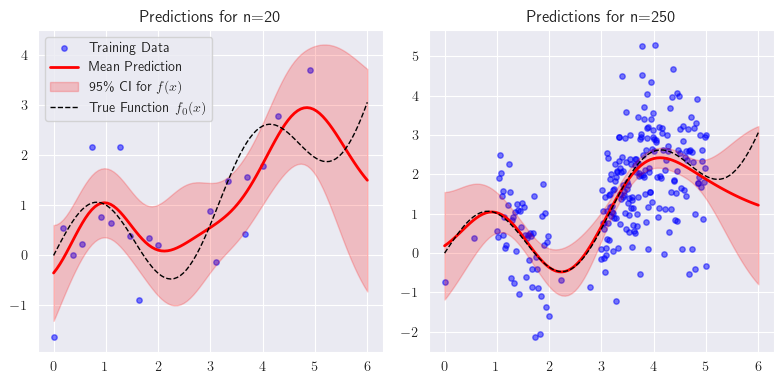

In [37]:
import numpy as np
import torch
from easygpr import GPRModel
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set the random seed
seed = 235789
torch.manual_seed(seed)
np.random.seed(seed)

# Define the underlying function
def f(x):
    return 0.1 * x ** 2 + np.sin(x * 2)

# Generate synthetic training data with noise for n=20
x_train_20 = np.hstack((np.linspace(0, 2, 12), np.linspace(3.1, 4.9, 4), np.linspace(3, 4, 4)))
y_train_20 = f(x_train_20) + np.random.normal(0, 1, x_train_20.shape)

# Reshape x_train_20 to 2D array
x_train_20 = x_train_20.reshape(-1, 1)

# Generate synthetic training data with noise for n=250
x_train_250 = np.hstack((np.linspace(1, 2, 50), np.linspace(3, 5, 140), np.linspace(0, 5, 10), np.linspace(3, 4, 50)))
y_train_250 = f(x_train_250) + np.random.normal(0, 1, x_train_250.shape)

# Reshape x_train_250 to 2D array
x_train_250 = x_train_250.reshape(-1, 1)

# Create GPR model for n=20 and n=250
m_20 = GPRModel(train_x=x_train_20, train_y=y_train_20, kernel="rbf")
m_20.fit_model()

m_250 = GPRModel(train_x=x_train_250, train_y=y_train_250, kernel="rbf")
m_250.fit_model()


# Create a range of test inputs
x_test = torch.linspace(0, 6, 100)

# Create GPR model for n=20 and n=250
m_20 = GPRModel(train_x=x_train_20, train_y=y_train_20, kernel="rbf")
m_20.fit_model()

m_250 = GPRModel(train_x=x_train_250, train_y=y_train_250, kernel="rbf")
m_250.fit_model()

# Make predictions for n=20 and n=250
predictions_20 = m_20.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_250 = m_250.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

# Update plot parameters to enhance readability
# Set up plot parameters to ensure sufficient font size and quality
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'medium',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'font.size': 12,
    'text.usetex': True
}
pylab.rcParams.update(params)



# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

x_test_np = np.linspace(0, 6, 100)  # Convert x_test to a numpy array for plotting

# Function to plot the graphs
def plot_graph(ax, x_train, y_train, predictions, title, color, legend = True):
    ax.scatter(x_train, y_train, label='Training Data', color='blue', s=15, marker='o', alpha = 0.5)
    ax.plot(x_test_np, predictions.mean, label='Mean Prediction', color=color, linewidth=2)
    ax.fill_between(x_test_np, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color=color, label='95\% CI for $f(x)$')
    ax.plot(x_test_np, f(x_test_np), '--', label='True Function $f_0(x)$', color='black', linewidth=1)
    if legend:
        ax.legend(loc='upper left', fontsize=10, labelspacing=0.5, framealpha=0.8)
    ax.set_title(title)

# Plot predictions for n=20 and n=250
plot_graph(axes[0], x_train_20, y_train_20, predictions_20, 'Predictions for n=20', 'red')
plot_graph(axes[1], x_train_250, y_train_250, predictions_250, 'Predictions for n=250', 'red', legend = False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('synthetic1_GP-n20-vs-250.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()


Fitting complete.
--- 
--- final mll: -1.4444
--- num_params: 4
--- BIC: 18.6161


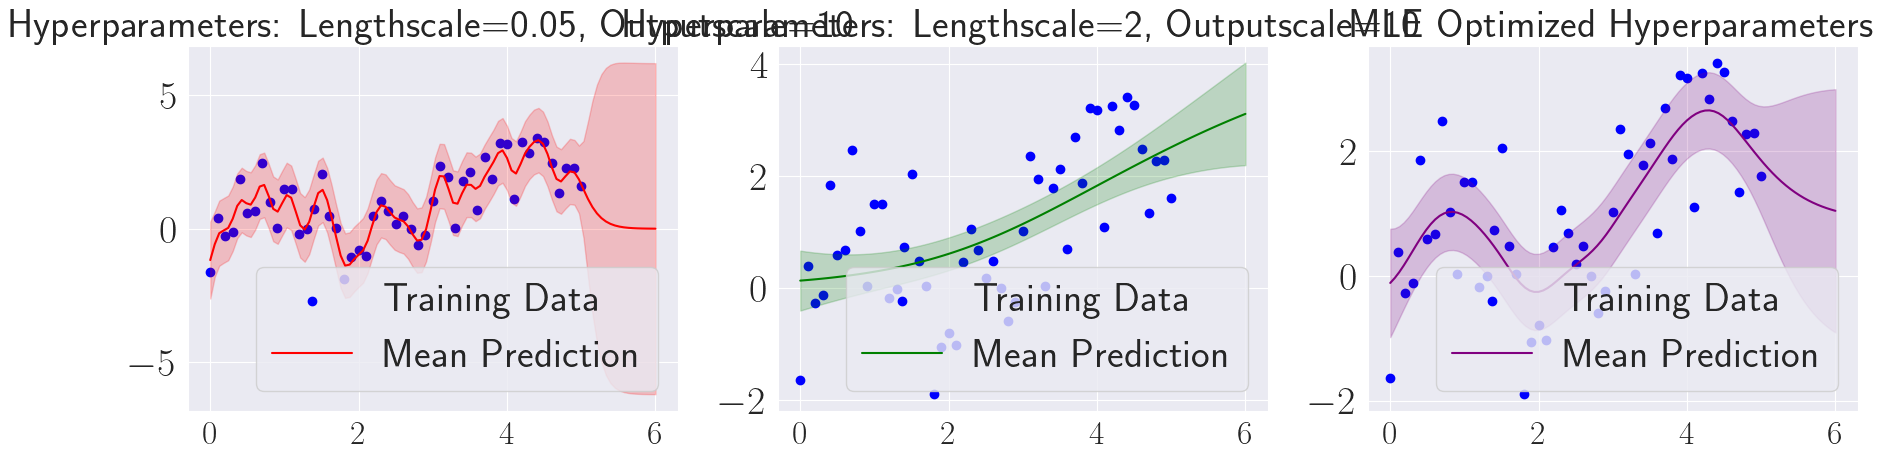

In [14]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from easygpr import GPRModel, utils
import matplotlib.pyplot as plt

# Seed for reproducibility
seed = 235789
torch.manual_seed(seed)
np.random.seed(seed)

# Define the underlying function
def f(x):
    return 0.1 * x ** 2 + np.sin(x * 2)

# Generate synthetic training data with noise
x_train = np.linspace(0, 5, 51)
y_train = f(x_train) + np.random.normal(0, 1, x_train.shape)

# Generate an additional 50 points as test set
x_test = np.linspace(0, 6, 100)
y_test = f(x_test) + np.random.normal(0, 1, x_test.shape)

# Convert to PyTorch tensors and scale data
scaler = MinMaxScaler()
scaler.fit(x_train.reshape(-1, 1))

train_x = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)

train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)
train_x_std = torch.tensor(scaler.transform(train_x.cpu()), dtype=torch.float32)
test_x_std = torch.tensor(scaler.transform(test_x.cpu()), dtype=torch.float32)

# Define models with varying hyperparameters
m1 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m1.covar_module.base_kernel.lengthscale = 0.05
m1.covar_module.outputscale = 10

m2 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m2.covar_module.base_kernel.lengthscale = 2
m2.covar_module.outputscale = 10

m3 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m3.fit_model(training_iterations=500, cosine_annealing=True)



# Function to make predictions and plot
def make_plot(model, ax, color, title):
    predictions = model.make_predictions(test_x_std, type="f", return_type="numpy")
    ax.scatter(x_train, y_train, label='Training Data', color='blue')
    ax.plot(x_test, predictions.mean, label='Mean Prediction', color=color)
    ax.fill_between(x_test, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color=color)
    ax.set_title(title)
    ax.legend()

# Create subplot layout and plot predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
make_plot(m1, axes[0], 'red', 'Hyperparameters: Lengthscale=0.05, Outputscale=10')
make_plot(m2, axes[1], 'green', 'Hyperparameters: Lengthscale=2, Outputscale=10')
make_plot(m3, axes[2], 'purple', 'MLE Optimized Hyperparameters')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('path_to_the_posterior_hyperparameters_plot.png', dpi=300)




In [15]:
from sklearn.metrics import mean_squared_error
import pandas as pd

m4 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Exponential")
m4.fit_model(training_iterations=500, cosine_annealing=True)

# Function to calculate RMSE and BIC
def calculate_metrics(model, train_x, train_y, test_x, test_y):
    train_pred = model.make_predictions(train_x, type="f", return_type="numpy")
    test_pred = model.make_predictions(test_x, type="f", return_type="numpy")
    
    train_rmse = np.sqrt(mean_squared_error(train_y.cpu().numpy(), train_pred.mean))
    test_rmse = np.sqrt(mean_squared_error(test_y, test_pred.mean))
    
    bic = model.bic
    
    return train_rmse, test_rmse, bic

# Gather metrics and hyperparameters for table
models = [m1, m2, m3, m4]
data = []
for i, model in enumerate(models, 1):
    lengthscale = round(model.covar_module.base_kernel.lengthscale.item(), 4)
    outputscale = round(model.covar_module.outputscale.item(), 4)
    noise = round(model.likelihood.noise.item(), 4)
    model.compute_bic()
    train_rmse, test_rmse, bic = calculate_metrics(model, train_x_std, train_y, test_x_std, y_test)
    bic = bic.item()
    data.append([f'm{i}', lengthscale, outputscale, noise, round(bic, 4), round(train_rmse, 4), round(test_rmse, 4)])

# Create a DataFrame
df = pd.DataFrame(data, columns=["Model", "Lengthscale", "Outputscale", "Noise", "BIC", "Train RMSE", "Test RMSE"])

# Convert the DataFrame to a LaTeX table
print(df.to_latex(index=False))


Fitting complete.
--- 
--- final mll: -1.4385
--- num_params: 4
--- BIC: 18.6042
\begin{tabular}{lrrrrrr}
\toprule
Model & Lengthscale & Outputscale & Noise & BIC & Train RMSE & Test RMSE \\
\midrule
m1 & 0.050000 & 10.000000 & 0.693200 & 19.183600 & 0.434500 & 1.377800 \\
m2 & 2.000000 & 10.000000 & 0.693200 & 19.061400 & 1.042500 & 1.083500 \\
m3 & 0.170500 & 1.134600 & 0.770600 & 18.616100 & 0.816400 & 1.066300 \\
m4 & 0.166900 & 1.282500 & 0.551600 & 18.604200 & 0.598300 & 1.073800 \\
\bottomrule
\end{tabular}


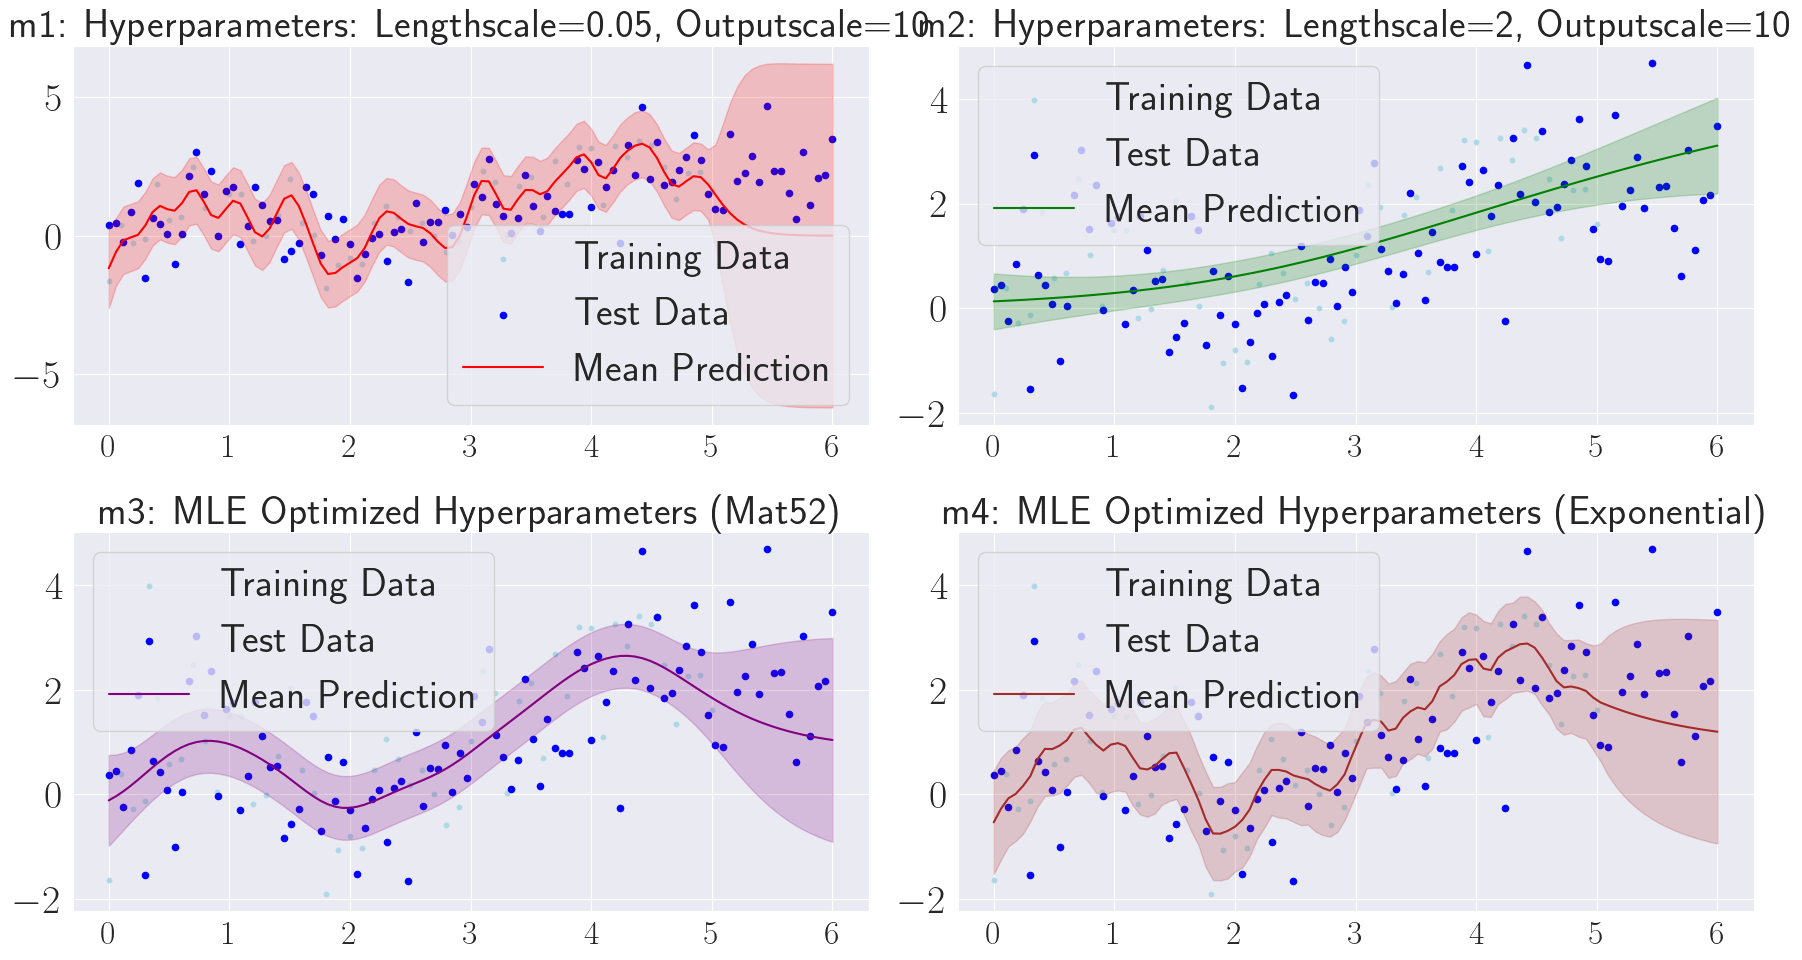

In [16]:

# Function to make enhanced plots utilizing both training and test sets
def make_enhanced_plot(model, ax, color, title):
    predictions = model.make_predictions(test_x_std, type="f", return_type="numpy")
    ax.scatter(x_train, y_train, label='Training Data', color='lightblue', s=10)
    ax.scatter(x_test, y_test, label='Test Data', color='blue', s=20)
    ax.plot(x_test, predictions.mean, label='Mean Prediction', color=color)
    ax.fill_between(x_test, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color=color)
    ax.set_title(title)
    ax.legend()

# Create subplot layout and plot predictions with enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
make_enhanced_plot(m1, axes[0, 0], 'red', 'm1: Hyperparameters: Lengthscale=0.05, Outputscale=10')
make_enhanced_plot(m2, axes[0, 1], 'green', 'm2: Hyperparameters: Lengthscale=2, Outputscale=10')
make_enhanced_plot(m3, axes[1, 0], 'purple', 'm3: MLE Optimized Hyperparameters (Mat52)')
make_enhanced_plot(m4, axes[1, 1], 'brown', 'm4: MLE Optimized Hyperparameters (Exponential)')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('enhanced_posterior_hyperparameters_plot.png', dpi=300)

In [19]:
from matplotlib.lines import Line2D

plt.rcParams['text.usetex'] = True

# Update plot parameters to increase font sizes and other style settings
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'x-large',
          'font.size': 20,
          'text.usetex': True}
import matplotlib.pylab as pylab
pylab.rcParams.update(params)

from easygpr.utils.data_handling import to_numpy
# Function to make enhanced plots utilizing both training and test sets
def make_enhanced_plot(models, ax, colors, title, emphasize_test_data=True, include_confidence_bands=False):
    # Generate a mesh of 200 points for smooth predictions
    x_mesh = np.linspace(0, 6, 200)
    x_mesh_std = torch.tensor(scaler.transform(x_mesh.reshape(-1, 1)), dtype=torch.float32)
    
    # Define the true underlying function
    f_0 = 0.1 * x_mesh**2 + np.sin(2 * x_mesh)
    ax.plot(x_mesh, f_0, color='grey', linestyle='-', linewidth=1, label='$f_0(x) = 0.1x^2 + \sin(2x)$')
    
    # Change marker size to emphasize different datasets in each panel
    ax.scatter(x_train, y_train, label='Training', color='blue', s=30, marker='o')
    ax.scatter(x_test, y_test, label='Test', color='green', s=30, marker='x')
    
    # Exclude edge points and select 10 roughly equally spaced indices
    selected_indices = np.linspace(5, len(x_test) - 6, 10, dtype=int)
    
    for model, color in zip(models, colors):
        predictions_f = model.make_predictions(x_mesh_std, type="f", return_type="numpy")
        predictions_y = model.make_predictions(x_mesh_std, type="y", return_type="numpy")
        ax.plot(x_mesh, predictions_f.mean, label=f'{model.name}', color=color, linewidth=2)
        
        if include_confidence_bands:
            ax.fill_between(x_mesh, predictions_f.mean - 1.96 * np.sqrt(predictions_f.variance),
                            predictions_f.mean + 1.96 * np.sqrt(predictions_f.variance), alpha=0.2, color=color,
                            label='95\% CI for f')
            ax.fill_between(x_mesh, predictions_y.mean - 1.96 * np.sqrt(predictions_y.variance),
                            predictions_y.mean + 1.96 * np.sqrt(predictions_y.variance), alpha=0.2, color=color,
                            linestyle='dashed', label='95\% PI for y')
        
        # Adding residuals for a subset of the test data in the right plot
    if len(models) == 1:
        for idx in selected_indices:
            x_val, y_val = x_test[idx], y_test[idx]
            y_pred = float(model.make_predictions(torch.tensor(scaler.transform([[x_val]]), dtype=torch.float32), type="f", return_type="numpy").mean)
            ax.plot([x_val, x_val], [y_val, y_pred], color='black', linestyle='--', linewidth=2)  # Darker and thicker lines

    ax.set_title(title)




C:\Users\jrisk\AppData\Local\Temp\ipykernel_16544\1380272201.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = float(model.make_predictions(torch.tensor(scaler.transform([[x_val]]), dtype=torch.float32), type="f", return_type="numpy").mean)
C:\Users\jrisk\AppData\Local\Temp\ipykernel_16544\1380272201.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = float(model.make_predictions(torch.tensor(scaler.transform([[x_val]]), dtype=torch.float32), type="f", return_type="numpy").mean)
C:\Users\jrisk\AppData\Local\Temp\ipykernel_16544\1380272201.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is 

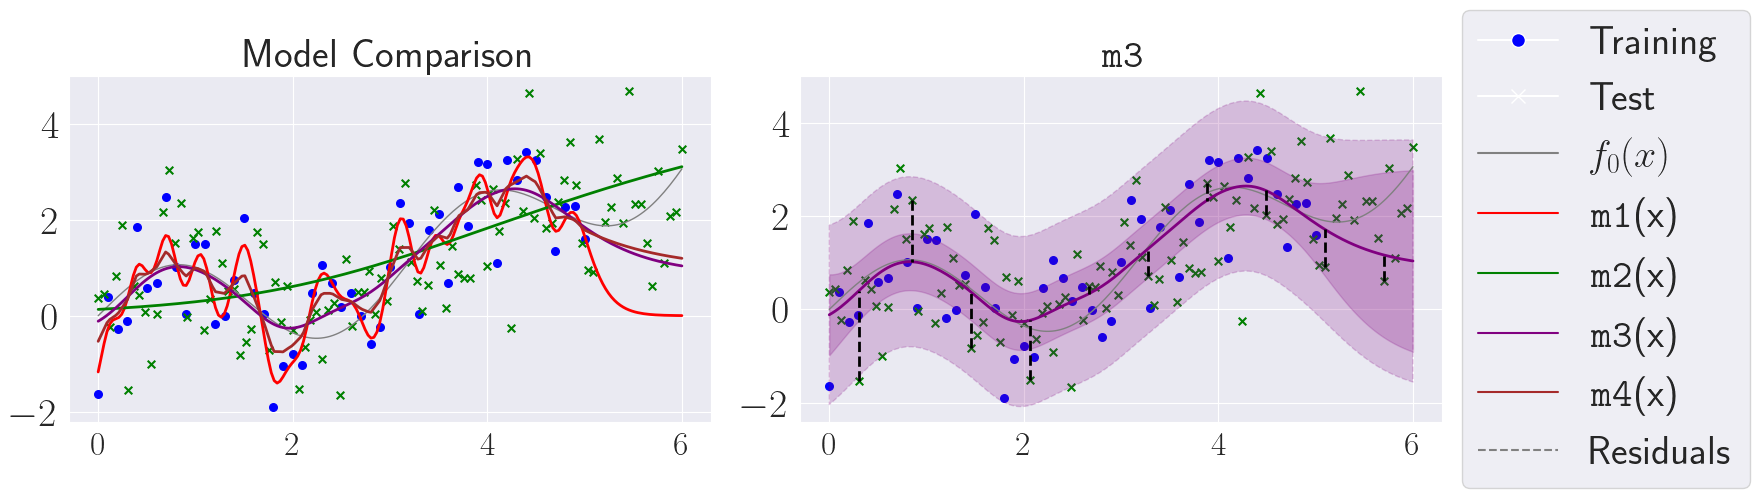

In [20]:
# Create subplot layout and plot predictions with enhanced visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Set names for the models for easier referencing in the plot labels
m1.name, m2.name, m3.name, m4.name = '\\texttt{m1}', '\\texttt{m2}', '\\texttt{m3}', '\\texttt{m4}'

make_enhanced_plot([m1, m2, m3, m4], axes[0], ['red', 'green', 'purple', 'brown'], 'Model Comparison', emphasize_test_data=False)
make_enhanced_plot([m3], axes[1], ['purple'], '\\texttt{m3}', include_confidence_bands=True)

# Custom handles for unified legend
custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Training', markersize=10, markerfacecolor='blue'), 
    Line2D([0], [0], marker='x', color='w', label='Test', markersize=10, markerfacecolor='green'), 
    Line2D([0], [0], linestyle='-', color='grey', label='$f_0(x)$'),
    Line2D([0], [0], linestyle='-', color='red', label='\\texttt{m1}(x)'),
    Line2D([0], [0], linestyle='-', color='green', label='\\texttt{m2}(x)'),
    Line2D([0], [0], linestyle='-', color='purple', label='\\texttt{m3}(x)'),
    Line2D([0], [0], linestyle='-', color='brown', label='\\texttt{m4}(x)'),
    Line2D([0], [0], linestyle='--', color='gray', linewidth=1.5, label='Residuals')
]

# Adding unified legend
axes[1].legend(handles=custom_handles, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('enhanced_posterior_hyperparameters_plot.png', dpi=300)